# **Object Detection with SSD**

**Tensorflow Edition**

SSD is a single-shot detector. It has no delegated region proposal network and predicts the boundary boxes and the classes directly from feature maps in one single pass. To improve accuracy, SSD introduces: small convolutional filters to predict object classes and offsets to default boundary boxes.

<img src ="https://www.mdpi.com/applsci/applsci-09-01128/article_deploy/html/images/applsci-09-01128-g004.png">

## **Install the Model**

Make sure you have `pycocotools` installed:

In [1]:
!pip install pycocotools

Make sure you have `tf_slim` installed:

In [2]:
!pip install tf_slim

     |████████████████████████████████| 358kB 6.5MB/s 


### Get `tensorflow/models` or `cd` to parent directory of the repository:

In [3]:
import os
import pathlib

!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2402, done.
remote: Counting objects: 100% (2402/2402), done.
remote: Compressing objects: 100% (1996/1996), done.
remote: Total 2402 (delta 563), reused 1456 (delta 379), pack-reused 0
Receiving objects: 100% (2402/2402), 30.77 MiB | 27.33 MiB/s, done.
Resolving deltas: 100% (563/563), done.


### Compile protobufs and install the *`object_detection`* package:

In [4]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [5]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1378388 sha256=1a75a3a5605dfbb119fdfa79252e22d3c09f3c7a969de1bfaf1b5b1c7c6073cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-hnwhcug_/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


### **Import the Required Libraries**

In [6]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

### **Import the object detection module:**

In [7]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### **Model Preparation**

### **Loader**

In [8]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

### **Loading label map**
Label maps map indices to category names so that when our convolution network predicts 5, we know that this corresponds to an airplane:

In [9]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity, we will test on 2 images:

In [10]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

## **Object Detection Model using TensorFlow API**
Load an object detection model:

In [11]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

76537856/76534733 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


**Check the model’s input signature (it expects a batch of 3-color images of type int8):**

In [12]:
print(detection_model.inputs)
detection_model.output_dtypes

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

## **Add a wrapper function to call the model and cleanup the outputs:**

In [13]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [14]:

def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [15]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

Output hidden; open in https://colab.research.google.com to view.

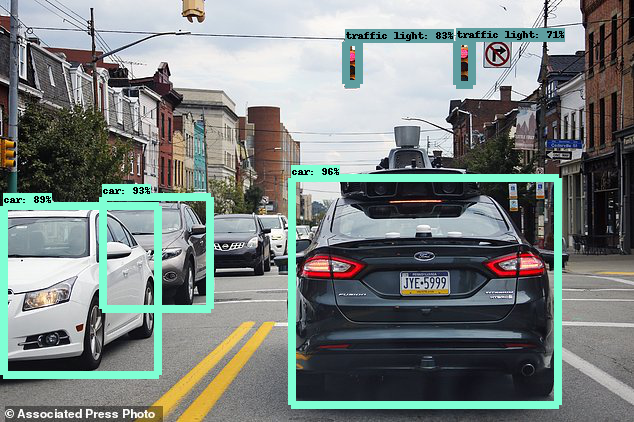

In [20]:
link = "/content/wire-552611-1494523075-954_634x422.jpg"
show_inference(detection_model, link)